# Salinity Drift Corrections for Global Wire Following Profilers


## Purpose
This notebook provides an example outline of different methods for correcting the offset in conductivity measurments observed in some global wire following profiler conductivity and salinity data. This notebook assumes you have downloaded the Lower Wire-Following-Profiler CTD data for Deployment 5 from the Global Station Papa Apex Hybrid Profiler Mooring (reference designator GP02HYPM-WFP03-04-CTDPFL000). 

## Introduction
There is an offset in the observed conductivity and salinity which occurs at the start of some of the deployments of Global Wire Following Profilers (GWFP). This offset decays over time in an exponential fashion until it converges with the expected seawater conductivity as measured by the sensor absent any interference. The offset is observed across arrays, profilers, and deployments [Figure 1]. However, its occurrence is not predictable: for example, it occurs on the third deployment of lower GWFP of the Global Southern Ocean Profiler Mooring, but not on the two preceding deployments [Figure 2].

Conversation with Sea-Bird Instruments indicated that this is a previously identified problem and was first observed in Argo float data (Sea-Bird Application Note 97). The cause of the conductivity offset is fouling of the conductivity cell by the Tributyl Tin (TBT) antifouling capsule. Sea-Bird suggests that if the TBT capsule is not thoroughly dried before shipping, the TBT may leak from the capsule and may form a viscous film over the conductivity cell that interferes with the conductivity measurement. The film is gradually washed-away once the instrument is deployed. This explains the decaying exponential curve behavior in the offset. Additionally, the requirement that the TBT not be fully dried for this effect to occur explains the irregular occurrence. 

In [1]:
# Import libraries that will be used
import os, sys, re
import time
import pandas as pd
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

/home/areed/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt

In [ ]:
# Import the ooinet M2M functions
sys.path.append("/home/areed/Documents/OOI/reedan88/ooinet/")
from ooinet import M2M
from ooinet.utils import convert_time, ntp_seconds_to_datetime, unix_epoch_time
from ooinet.Instrument.common import add_annotation_qc_flag, process_file

### Load the Dataset
There are two functions which are defined to reprocess and load the netCDF files for ease-of-use. They rework the netCDF files and then open/append them together.

In [3]:
def process_file(ds):
    """
    Function to download one of the NetCDF files as an xarray data set, convert
    to time as the appropriate dimension instead of obs, and drop the
    extraneous timestamp variables (these were originally not intended to be
    exposed to users and have lead to some confusion as to their meaning). The
    ID and provenance variables are better off obtained directly from the M2M
    system via a different process. Having them included imposes unnecessary
    constraints on the processing, so they are also removed.

    :param catalog_file: Unique file, referenced by a URL relative to the
        catalog, to download and then convert into an xarray data set.
    :param gc: Boolean flag to indicate whether the file is from the Gold
        Copy THREDDS server (gc = True), or the user's M2M THREDDS catalog
        (gc = False, default).
    :return: downloaded data in an xarray dataset.
    """
    # addresses error in how the *_qartod_executed variables are set
    qartod_pattern = re.compile(r'^.+_qartod_executed$')
    for v in ds.variables:
        if qartod_pattern.match(v):
            # the shape of the QARTOD executed variables should compare to the provenance variable
            try:
                if ds[v].shape != ds['provenance'].shape:
                    ds = ds.drop_vars(v)
            except:
                pass

    # convert the dimensions from obs to time and get rid of obs and other variables we don't need
    ds = ds.swap_dims({'obs': 'time'})
    ds = ds.reset_coords()
    keys = ['obs', 'id', 'provenance', 'driver_timestamp', 'ingestion_timestamp',
            'port_timestamp', 'preferred_timestamp']
    for key in keys:
        if key in ds.variables:
            ds = ds.drop_vars(key)

    # since the CF decoding of the time is failing, explicitly reset all instances where the units are
    # seconds since 1900-01-01 to the correct CF units and convert the values to datetime64[ns] types
    time_pattern = re.compile(r'^seconds since 1900-01-01.*$')
    ntp_date = np.datetime64('1900-01-01')
    for v in ds.variables:
        if 'units' in ds[v].attrs.keys():
            if isinstance(ds[v].attrs['units'], str):  # because some units use non-standard characters...
                if time_pattern.match(ds[v].attrs['units']):
                    del(ds[v].attrs['_FillValue'])  # no fill values for time!
                    ds[v].attrs['units'] = 'seconds since 1900-01-01T00:00:00Z'
                    np_time = ntp_date + (ds[v] * 1e9).astype('timedelta64[ns]')
                    ds[v] = np_time

    # sort by time
    ds = ds.sortby('time')

    # clear-up some global attributes we will no longer be using
    keys = ['DODS.strlen', 'DODS.dimName',
            'DODS_EXTRA.Unlimited_Dimension', '_NCProperties', 'feature_Type']
    for key in keys:
        if key in ds.attrs:
            del(ds.attrs[key])

    keys = list(ds.encoding.keys())
    for key in keys:
        if key == 'unlimited_dims':
            del ds.encoding[key]

    # resetting cdm_data_type from Point to Station and the featureType from point to timeSeries
    ds.attrs['cdm_data_type'] = 'Station'
    ds.attrs['featureType'] = 'timeSeries'

    # update some of the global attributes
    ds.attrs['acknowledgement'] = 'National Science Foundation'
    ds.attrs['comment'] = 'Data collected from the OOI M2M API and reworked for use in locally stored NetCDF files.'

    return ds


def load_wfp(FILE_DIR, deploymentNumber):
    """
    Open and load the data from a deployment for a given GWFP. Data
    must already have been downloaded either from ooinet.oceanobservatories.org
    or dataexplorer.oceanobservatories.org as netCDF files.
    """
    deployment = "deployment" + str(int(deploymentNumber)).zfill(4)
    files = sorted([FILE_DIR + f for f in os.listdir(FILE_DIR) if deployment in f])
    for file in files:
        dset = xr.open_dataset(file)
        dset = process_file(dset)
        try:
            data = xr.concat([data, dset], dim="time")
            data = data.sortby("time")
        except:
            data = dset
        
    return data

In [4]:
# Load the Papa Deployment 5 GWFP dataset
DATA_DIR = "data/GP02HYPM-WFP03-04-CTDPFL000/recovered_wfp/"
Data = load_wfp(DATA_DIR, 5)

---
### The Salinity Drift
First, we're going to plot the salinity along several different isotherms in the profile of the WFP. We plot the data along isotherms in order to reduce the impact of temperature, which has a major effect of conductivity and consequently salinity. Thus, to minimize the effect of temperature, we will look at conductivity/salinity along an isotherm.

Get the range of temperatures for the profiler:

In [5]:
Tmin = Data.ctdpf_ckl_seawater_temperature.min().values
Tmax = Data.ctdpf_ckl_seawater_temperature.max().values
print(f"Minimum observed temperature: {np.round(Tmin, 4)}")
print(f"Maximum observed temperature: {np.round(Tmax, 4)}")

Minimum observed temperature: 1.4941
Maximum observed temperature: 1.9194


Plot the conductivity and salinity along several isotherms:

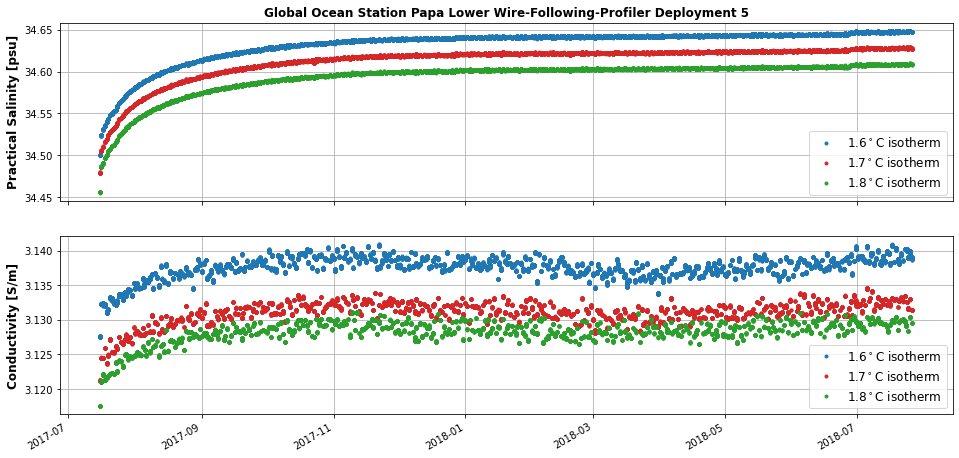

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# Plot the salinity along the 1.6C isotherm
isotherm = 1.6
interval = 0.001
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-interval) & (Data.ctdpf_ckl_seawater_temperature <= isotherm+interval)

ax[0].plot(Data.time[mask], Data.practical_salinity[mask], marker=".", linestyle="", color="tab:blue", label=f"{isotherm}$^\circ$C isotherm")
ax[1].plot(Data.time[mask], Data.ctdpf_ckl_seawater_conductivity[mask], marker=".", linestyle="", color="tab:blue", label=f"{isotherm}$^\circ$C isotherm")

# Plot the salinity along the 1.7C isotherm
isotherm = 1.7
interval = 0.001
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-interval) & (Data.ctdpf_ckl_seawater_temperature <= isotherm+interval)

ax[0].plot(Data.time[mask], Data.practical_salinity[mask], marker=".", linestyle="", color="tab:red", label=f"{isotherm}$^\circ$C isotherm")
ax[1].plot(Data.time[mask], Data.ctdpf_ckl_seawater_conductivity[mask], marker=".", linestyle="", color="tab:red", label=f"{isotherm}$^\circ$C isotherm")

# Plot the salinity along the 1.8C isotherm
isotherm = 1.8
interval = 0.001
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-interval) & (Data.ctdpf_ckl_seawater_temperature <= isotherm+interval)

ax[0].plot(Data.time[mask], Data.practical_salinity[mask], marker=".", linestyle="", color="tab:green", label=f"{isotherm}$^\circ$C isotherm")
ax[1].plot(Data.time[mask], Data.ctdpf_ckl_seawater_conductivity[mask], marker=".", linestyle="", color="tab:green", label=f"{isotherm}$^\circ$C isotherm")

ax[0].set_ylabel("Practical Salinity [psu]", fontsize=12, weight="bold")
ax[0].legend(fontsize=12)
ax[0].grid()
ax[0].set_title("Global Ocean Station Papa Lower Wire-Following-Profiler Deployment 5", fontsize=12, weight="bold")

ax[1].set_ylabel("Conductivity [S/m]", fontsize=12, weight="bold")
ax[1].legend(fontsize=12)
ax[1].grid()

fig.autofmt_xdate()

In [7]:
#fig.savefig("Papa_Deployment5.png", transparent=False, facecolor="white")

The plot above shows the salinity drift at different isotherms throughout the WFP profile. To the eye the curves look similar, just converging on a different salinity/conductivity values. 

---
## Modelling the interference
Next, we want to model the interference to best replicate the apparent shape of the curves observed in the plot above. We start by describing the conductivity measured by the GWFP as a simple equation where the observed conductivity at time $t$ ($C_{obs}(t)$) is equal to the actual seawater conductivity ($C_{sw}(t)$) plus the offset due to TBT interference (${\Delta}C(t)$) and some independent measurement error (${\epsilon}$): <br><br>

<div align="center">
$Eq. 1: C_{obs}(t) = C_{sw}(t) + {\Delta}C(t) + {\epsilon}$
</div>

Based on the conversations with Sea-Bird, the offset in conductivity is likely a physical interference effect of the TBT antifouling agent and that the magnitude of the interference is proportional to the thickness of the TBT film. Once the deployment starts, the conductivity cell is flushed with water which washes away the TBT film. Thus, the conductivity offset due to TBT interference is largest at the start of the deployment and decreases in proportion to the flushing of the cell. We model the TBT interference and flushing as an exponential function: <br><br>

<div align="center">
$Eq. 2: {\Delta}C(t) = {\gamma}{\cdot}[TBT]_{0}e^{-t / {\tau}}$
</div>

where $[TBT]_{0}$ is the initial concentration of tributyltin on the conductivity cell, ${\gamma}$ is a conversion factor which converts the TBT interference into a conductivity value (with units of S/m per unit of TBT), and ${\tau}$ is the flushing rate. We further simplify this into: <br><br>

<div align="center">
$Eq. 3: {\Delta}C(t) = {\Delta}C_{0}e^{-t / {\tau}}$
</div>
    
Equation 3 describes a conductivity offset which is greatest at the start of a deployment and decreases exponentially as a function of the flushing rate until the offset is zero, when the TBT is completely flushed out of the conductivity cell. At this point the conductivity cell should be measuring the seawater conductivity with no interference from TBT. The point at which the TBT has been completely flushed can roughly be assumed to be when  $t {\geq} 5{\tau}$ (${\Delta}C(t) {\leq} 0.04%$). <br><br>

We take the modeled interference of the TBT and C offset and substitute it back into Equation 1 to get:<br><br>

<div align="center">
$Eq. 4: C_{obs}(t) = C_{sw}(t) + {\Delta}C_{0}e^{-t / {\tau}} + {\epsilon}$
</div>
  
Equation 4 describes a time series of conductivity where, as $t {\rightarrow} {\infty}$ the conductivity offset ${\Delta}C(t) {\rightarrow} 0$, and the measured conductivity converges on the expected seawater conductivity, plus some measurement error. Importantly, Equation 4 makes no claim as to the accuracy of the conductivity measurement, which must be verified independently using co-located measurements, particularly ship-based observations.

In the above equations, we can substitute salinity $S$ for conductivity $C$ depending on whether we want to just correct for the offset in the practical salinity or you want to recompute salinity using corrected conductivity.

---
## Methods
Correcting for the salinity offset due to TBT interference requires several steps. First, the profiler salinity data should be binned by temperature. Since conductivity is highly sensitive to temperature, the conductivity and salinity corrections are done along isotherms to minimize the effect of temperature variations. 

### Curve fitting
Next, the binned data is fitted with Equation 4 using Ordinary-Least-Squares with one modification, which is splitting the actual seawater conductivity $C_{sw}(t)$ into two terms: a time dependent trend and a reference value. This results in the following equation which is fitted to the data:<br><br>

<div align="center">
    $Eq. 5: C_{obs}(t) = C_{0}+{\alpha}t+{\Delta}C_{0}e^{(-t/{\tau})}$
</div>

The value for ${\tau}$ is calculated for each salinity time series at each isotherm throughout the profile. Then, we combine the separately calculated values for ${\tau}$ using a weighted average to get an estimate of the overall ${\tau}$.  With the value of ${\tau}$, we now correct for the conductivity offset using either the Gain Correction method recommended by SeaBird or by explicitly calculating the offset using the results of curve fitting using Equation 5.


In [8]:
def equation_three(t, a, b):
    return a * np.exp(-t / b)

def equation_five(t, a, b, c, d):
    return a * np.exp(-t / b) + c*t + d

The time $t$ in the equation is not the datetime but the elasped time $t - t_{0}$. So first we calculate the elapsed time of a deployment in seconds and add it to our dataset:

In [9]:
def calculate_elapsed_time(ds):
    """Calculate the elapsed time in seconds"""
    dt = (ds.time - ds.time[0]).values.astype('timedelta64[s]').astype('int')
    dt = xr.DataArray(data=dt, coords={"time": ds.time}, dims="time", attrs=ds.time.attrs)
    ds["elapsed_time"] = dt
    ds["elapsed_time"].attrs.update({
        "units": "seconds"
    })
    
    return ds

In [10]:
Data = calculate_elapsed_time(Data)

Fit the data along the 1.8$^{\circ}$C isotherm ${\pm}$ 0.0005$^{\circ}$C:

In [12]:
from scipy.optimize import curve_fit

results = {}
isotherm = 1.8
interval = 0.0005

# Get the mask
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-interval) & (Data.ctdpf_ckl_seawater_temperature <= isotherm+interval)

# Get the data
t = Data.elapsed_time[mask].values - Data.elapsed_time[mask].values[0]
y = Data.practical_salinity[mask].values
n = len(y)
# Fit the data
popt, pcov = curve_fit(equation_five, t, y)
# Calculate the standard deviation
pstd = np.sqrt(np.diag(pcov))
# Get the results
a, b, c, d = popt[0], popt[1], popt[2], popt[3]
a_std, b_std, c_std, d_std = pstd[0], pstd[1], pstd[2], pstd[3]
# Save the results in a pandas dataframe
results.update({
    "isotherm": isotherm,
    "a": a,
    "a_std": a_std,
    "b": b,
    "b_std": b_std,
    "c": c,
    "c_std": c_std,
    "d": d,
    "d_std": d_std,
    "n": n
})

results

{'isotherm': 1.8,
 'a': -0.10297618471566214,
 'a_std': 0.0002506868120537781,
 'b': 2363053.141517883,
 'b_std': 11684.269521147584,
 'c': 4.664782981761712e-10,
 'c_std': 6.083329536411598e-12,
 'd': 34.59320840631505,
 'd_std': 0.00013083104477752013,
 'n': 3857}

The results above give us:
* ${\Delta}C_{0}(t_{0})$ (a) = -0.10297 psu
* ${\tau}$ (b) = 2363053 seconds (27.35 days)
* ${\alpha}$ (c) = 4.6648E-10 psu/second
* $C_{0}$ (d) = 34.5932 psu

Plot the data along the 1.8$^{\circ}$C isotherm with the fitted Equation 5:

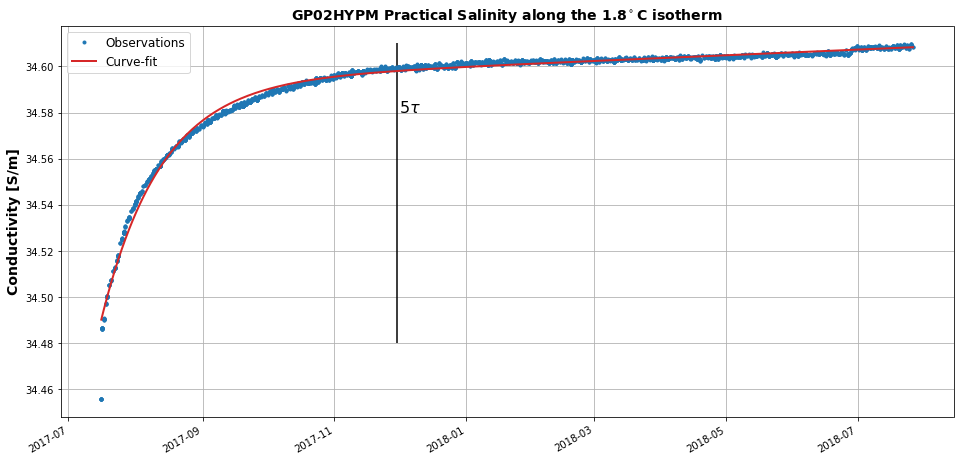

In [13]:
# Get the relevant curve-fit data
a, b, c, d = results["a"], results["b"], results["c"], results["d"]
t = Data.elapsed_time[mask].values  - Data.elapsed_time[mask].values[0]

# Calculate the curve-fit
fitted_data = equation_five(t, a, b, c, d)

# Plot the results
fig, ax = plt.subplots(figsize=(16, 8))
ax.vlines(Data.time[Data.elapsed_time >= 5*b][0].values, 34.48, 34.61, colors="black")
ax.text(Data.time[Data.elapsed_time >= 5*b][10000].values, 34.58, r"5$\tau$", fontsize=16)
ax.plot(Data.time[mask], Data.practical_salinity[mask], color="tab:blue", marker=".", linestyle="",
        label="Observations")
ax.plot(Data.time[mask], fitted_data, color="tab:red", label="Curve-fit", linewidth=2)
ax.set_title(f"GP02HYPM Practical Salinity along the {isotherm}$^\circ$C isotherm", fontsize=14, fontweight="bold")
ax.set_ylabel("Conductivity [S/m]", fontsize=14, fontweight="bold")
ax.legend(fontsize=12)
ax.grid()
fig.autofmt_xdate()

#### Calculate ${\tau}$ for the entire profile
Next, we want to make an estimate for the flushing rate ${\tau}$ for the entire profile. We do this by iterating through each isotherm in the profile and fitting a curve to the salinity data along that isotherm, getting a range of estimates for ${\tau}$. Then we use a weighted average to get an estimate for the overall flushing rate.

First, get the range of temperatures in the profile:

In [14]:
Tmin = Data.ctdpf_ckl_seawater_temperature.min().values
Tmax = Data.ctdpf_ckl_seawater_temperature.max().values
Tmin, Tmax = np.ceil(Tmin*100)/100, np.floor(Tmax*100)/100
Tmin, Tmax

(1.5, 1.91)

Generate an array of isotherms throughout the profile:

In [15]:
interval = 0.002
isotherms = np.arange(Tmin, Tmax+interval, interval*2)
isotherms = np.round(isotherms, 4)
isotherms[60]

1.74

Define a function to calculate the standard deviation of each fit:

In [16]:
from scipy.optimize import least_squares

def calculate_std(y, y_hat):
    """Calculate the standard deviation of a fit given the observations y and best-fit y_hat"""
    return np.sqrt( np.sum( (y - y_hat)**2 ) / len(y) )

Calculate the curve-fits for each of the isotherms throughout the profile:

In [17]:
# Start a results dataframe to store the results from the fits
results = pd.DataFrame(columns=["isotherm", "a", "a_std", "b", "b_std", "c", "c_std", "n", "std"])

# Iterate through the isotherms and calculate the fits
for iso in isotherms:
    # Generate a mask based on the isotherm +/- interval
    mask = (Data.ctdpf_ckl_seawater_temperature >= iso-interval) & (Data.ctdpf_ckl_seawater_temperature < iso+interval)
    
    # # Get the data
    try:
        t = Data.elapsed_time[mask].values-Data.elapsed_time[mask].values[0]
        y = Data.practical_salinity[mask].values
        n = len(y)
    except:
        continue
    
    if n < 100:
        continue
    
    # Initialize the parameter guesses
    a = -(y.mean() - y[0])
    b = 0.5E7
    c = 0.001
    d = 34.6
    
    # Fit the data
    try:
        popt, pcov = curve_fit(equation_five, t, y, [a, b, c, d])
        # Calculate the standard deviation
        pstd = np.sqrt(np.diag(pcov))
        # Get the results
        a, b, c, d = popt[0], popt[1], popt[2], popt[3]
        a_std, b_std, c_std, d_std = pstd[0], pstd[1], pstd[2], pstd[3]
        
        # Calculate the least squares error
        y_hat = equation_five(t, a, b, c, d)
        std = calculate_std(y, y_hat)
        
    except RuntimeError:
        a, b, c, d = np.nan, np.nan, np.nan, np.nan
        a_std, b_std, c_std, d_std = np.nan, np.nan, np.nan, np.nan
        std = np.nan
    # Save the results in a pandas dataframe
    results = results.append({
        "isotherm": iso,
        "a": a,
        "a_std": a_std,
        "b": b,
        "b_std": b_std,
        "c": c,
        "c_std": c_std,
        "d": d,
        "d_std": d_std,
        "n": n,
        "std": std
    }, ignore_index=True)

Next, we want to remove fits which did not converge on a solution. We can do this knowing that the salinity should converge somewhere between 34 and 35 psu and that the flushing rate ${\tau}$ should be positive.

In [18]:
# Filter out fits which did not converge
results = results.dropna()
results = results[results["b"] > 0]
results = results[(results["d"] >=34) & (results["d"] <= 35)]

# Reset the dataframe index to zero
results = results.reset_index(drop=True)
results

,isotherm,a,a_std,b,b_std,c,c_std,n,std,d,d_std
0,1.500,-0.028951,0.000135,2.255656e+06,47129.426351,2.966772e-10,1.461271e-12,160842.0,0.001671,34.663580,0.000031
1,1.504,-0.114057,0.000052,2.254096e+06,1570.413171,3.615976e-10,7.999925e-13,303722.0,0.002716,34.660521,0.000018
2,1.508,-0.100616,0.000034,2.314649e+06,1747.089347,3.896007e-10,1.016030e-12,251365.0,0.002903,34.656907,0.000021
3,1.512,-0.100144,0.000041,2.426174e+06,2270.400133,3.665115e-10,1.186522e-12,122467.0,0.002302,34.655038,0.000025
4,1.516,-0.103218,0.000053,2.281669e+06,2484.594629,4.287781e-10,1.342316e-12,99518.0,0.002500,34.652113,0.000029
...,...,...,...,...,...,...,...,...,...,...,...
96,1.884,-0.112813,0.000172,2.022350e+06,6171.522155,5.827561e-10,4.030238e-12,18615.0,0.003386,34.573741,0.000087
97,1.888,-0.097600,0.000085,2.486559e+06,4986.609403,4.674574e-10,2.454256e-12,15178.0,0.001754,34.576102,0.000053
98,1.892,-0.095936,0.000099,2.533773e+06,4952.511689,4.783509e-10,2.403568e-12,13778.0,0.001586,34.574904,0.000054
99,1.896,-0.097931,0.000097,2.314270e+06,5644.418862,5.356265e-10,3.671127e-12,12062.0,0.002215,34.572663,0.000077


Finally, we can calculate a weighted mean of the all the fits to get a decent estimate of the curve for the entire profile. We will NOT combine either the trend or the base-level, since these are expected to deviate based on depth

In [19]:
def combine_fits(n1, m1, std1, n2, m2, std2):
    """Calculate the combined standard deviations for a given parameter"""
    # Combined obs
    combined_n = n1 + n2
    
    # Combine the means/fits
    combined_mean = (n1*m1 + n2*m2) / (n1 + n2)
    
    # Combined standard deviations
    n_std1 = (n1-1)*std1**2
    n_std2 = (n2-1)*std2**2
    weighted_m = (m1**2 + m2**2 - 2*m1*m2)
    combined_std = np.sqrt(( n_std1 + n_std2 + (n1 * n2) / (n1 + n2) * weighted_m) / (n1 + n2 -1))
    
    return combined_mean, combined_std, combined_n

In [20]:
# Initialize the combination
a1, a1_std, b1, b1_std, n1 = results[["a", "a_std", "b", "b_std", "n"]].loc[0]
a2, a2_std, b2, b2_std, n2 = results[["a", "a_std", "b", "b_std", "n"]].loc[1]
an1, bn1 = (n1, n1)
an2, bn2 = (n2, n2)
ind = 1

while ind < results.index.max():
    # Calculate the new combined values for everything except the level D and trend
    a1, a1_std, an1 = combine_fits(an1, a1, a1_std, an2, a2, a2_std)
    b1, b1_std, bn1 = combine_fits(bn1, b1, b1_std, bn2, b2, b2_std)

    # Index the next value
    ind = ind + 1
    
if ind == results.index.max():
    combined = {
        "a": a1,
        "a_std": a1_std,
        "b": b1,
        "b_std": b1_std,
        "n": an1
    }

The final weighted estimate of ${\tau}$ ("b" in the dictionary) is:

In [21]:
combined["b"] / (60*60*24)

26.08916669022594

In [22]:
mask = (Data.elapsed_time <= combined["b"]*5)
Data.time[mask].values[0], Data.time[mask].values[-1]

(numpy.datetime64('2017-07-16T04:00:03.000000000'),
 numpy.datetime64('2017-11-23T14:05:31.998670336'))

In [23]:
print(f"Response time tau = {combined['b']} seconds")

Response time tau = 2254104.0020355214 seconds


Consequently, we can see for Papa 5 Lower Wire Following Profiler that the average flusing time ${\tau}$ is 2254104 seconds ${\pm}$ 21528 seconds (or 26.09 ${\pm}$ 0.25 days). So it takes slightly over 4 months for the WFP to have flushed the TBT fouling out of the conductivity cell and converged on the expected seawater salinity.

---
## Salinity Corrections

### Method 1: Gain Correction

This first method uses the gain correction method explained in SeaBird's [Application Note 31](https://www.seabird.com/asset-get.download.jsa?id=54627861537). The gain correction equation is: <br><br>

<div align="center">
(corrected salinity) = slope * (measured salinity) + offset
</div>

We assume that the offset in the data is zero, since with enough time the observed salinity should converge on the actual seawater salinity. The slope is a correction-factor to correct for the offset due to the TBT interference: <br><br>

<div align="center">
slope = (reference salinity) / (measured salinity)
</div>

The most difficult decision is determining what the reference salinity should be. There are several options for estimating this. TThe first used here was to take the mean of the salinity after the apparent offset has disappeared, which can be which can assumed when $t \geq 5\tau$ (${\Delta}C(t) \leq 0.4%$):<br></br>

<div align="center">
    (reference salinity) = $C_{obs}(t), t>5$
</div>

Next, we calculate the slope value at each time point t using the calculated reference salinity and the measured salinity $C_{obs}(t)$. The resulting time series of slope values is subsequently smoothed using a centered running window; otherwise, all of the measurement error  is removed from the time series. 
The measured salinity is multiplied with the time series of smoothed slope values to calculate the corrected salinity: <br><br>

<div align="center">
    $C_{corr}(t) = slope_{smoothed}{\cdot}C_{obs}(t)$
</div>


This calculation is done separately for salinity at each isotherm, since the reference salinity is different throughout the profile.


In [24]:
# Select the isotherm to do the correction on 
isotherm = 1.800

# Select the data
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-0.0005) & (Data.ctdpf_ckl_seawater_temperature <= isotherm + 0.0005)

# Determine the reference salinity by calculating the reference salinity as the mean of the data greater than 
# 5 e-folding times
ref_sal = Data.practical_salinity[mask].where(Data.elapsed_time[mask] > 5*2062328).mean()

t = Data.elapsed_time[mask] - Data.elapsed_time[mask][0]
y = Data.practical_salinity[mask]

In [25]:
# Calculate the correction factor
slope = ref_sal / y
slope

<xarray.DataArray 'practical_salinity' (time: 3857)>
array([1.00427674, 1.00427812, 1.00427527, ..., 0.99981781, 0.99984109,
       0.99984626])
Coordinates:
  * time     (time) datetime64[ns] 2017-07-16T04:13:33.932106240 ... 2018-07-...

In [26]:
# Now smooth the correction factor
df = slope.to_dataframe("slope")
df = df.rolling(window=11, center=True).mean()
df.fillna(value=slope.to_dataframe("slope"), inplace=True)
slope_smoothed = xr.DataArray(df["slope"], dims="time")
slope_smoothed

<xarray.DataArray 'slope' (time: 3857)>
array([1.00427674, 1.00427812, 1.00427527, ..., 0.99981781, 0.99984109,
       0.99984626])
Coordinates:
  * time     (time) datetime64[ns] 2017-07-16T04:13:33.932106240 ... 2018-07-...

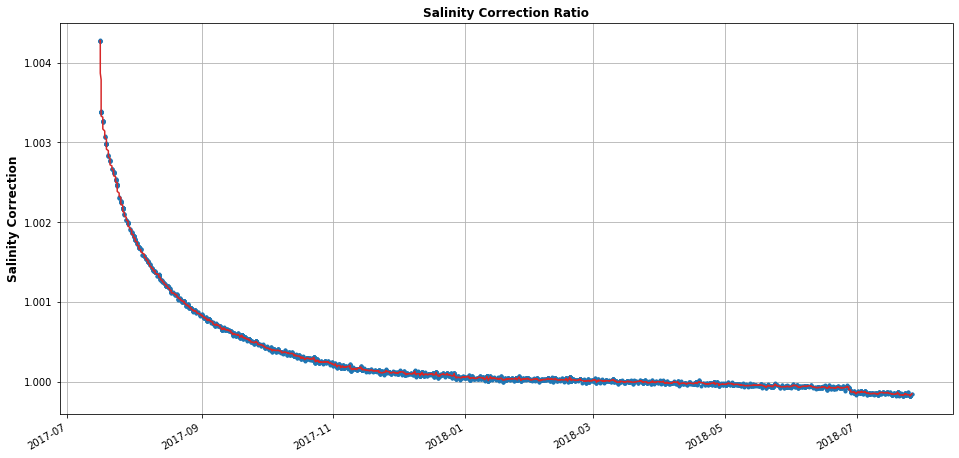

In [27]:
# Plot the correction factor
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(slope.time, slope, marker=".", color="tab:blue", linestyle="", label="Salinity Correction")
ax.plot(slope_smoothed.time, slope_smoothed, color="tab:red", label="Salinity Correction Smoothed")
ax.grid()
ax.set_ylabel("Salinity Correction", fontsize=12, weight="bold")
ax.set_title("Salinity Correction Ratio", fontsize=12, weight="bold")
fig.autofmt_xdate()

In [28]:
# Calculate the "corrected" salinity
sal_corrected = Data.practical_salinity*slope_smoothed

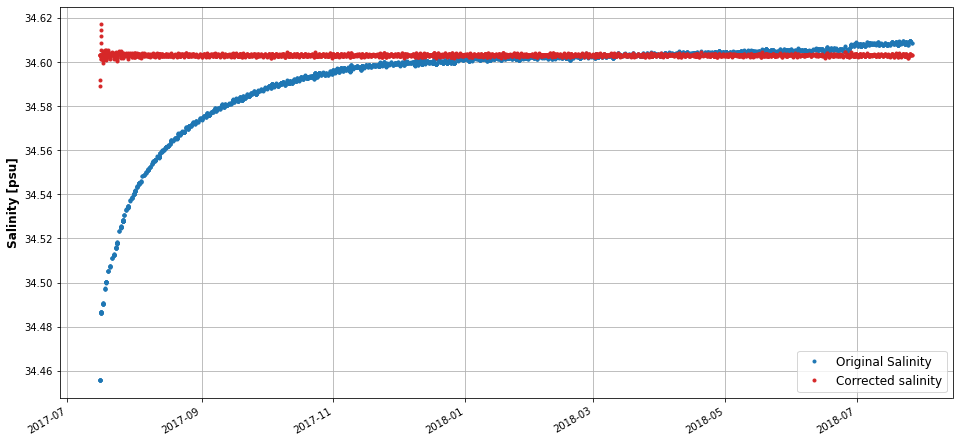

In [29]:
# Plot the original and corrected salinity
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(Data.time[mask], Data.practical_salinity[mask], marker=".", color="tab:blue", linestyle="", label="Original Salinity")
ax.plot(sal_corrected.time, sal_corrected, color="tab:red", marker=".", linestyle="", label="Corrected salinity")
ax.grid()
ax.set_ylabel("Salinity [psu]", fontsize=12, weight="bold")
ax.legend(fontsize=12)

fig.autofmt_xdate()

In the above plot, we see that the correct salinity has removed the offset. However, there may also be a trend in the salinity data that is not due to the TBT interference. 

### Method 1B: Remove the trend before Gain Correction
A second method for determining the reference salinity is to fit a regression, or other time-varying trend, to the salinity observations where $t\geq5\tau$. For example, we can fit a linear regression the selected observations and solve for the slope $\alpha$ and intercept $C_{0}$:<br><br>

<div align="center">
    $C_{obs}(t>5\tau)=C_{0}+{\alpha}t$
</div>

Conveniently, the intercept $C_{0}$ is the reference salinity for calculating the slope for correction. Additionally, this approach preserves any potential salinity signal in the time series.

In [30]:
from scipy.stats import linregress

In [31]:
# Select the data
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-0.0005) & (Data.ctdpf_ckl_seawater_temperature <= isotherm + 0.0005)

# Determine the reference salinity by calculating the reference salinity as the mean of the data greater than 
t = Data.elapsed_time[mask] - Data.elapsed_time[mask][0]
y = Data.practical_salinity[mask]

# Get the data after 5 e-folding times
tmask = (t >= 5*2062328)

# Calculate the linear regression
trend = linregress(t[tmask], y[tmask])

# Trend
print(f"Slope: {trend.slope}")
print(f"Intercept: {trend.intercept}")

Slope: 4.0789815604802983e-10
Intercept: 34.594556611144355


In [32]:
# Remove the trend from the signal
sal_no_trend = y - trend.slope*t

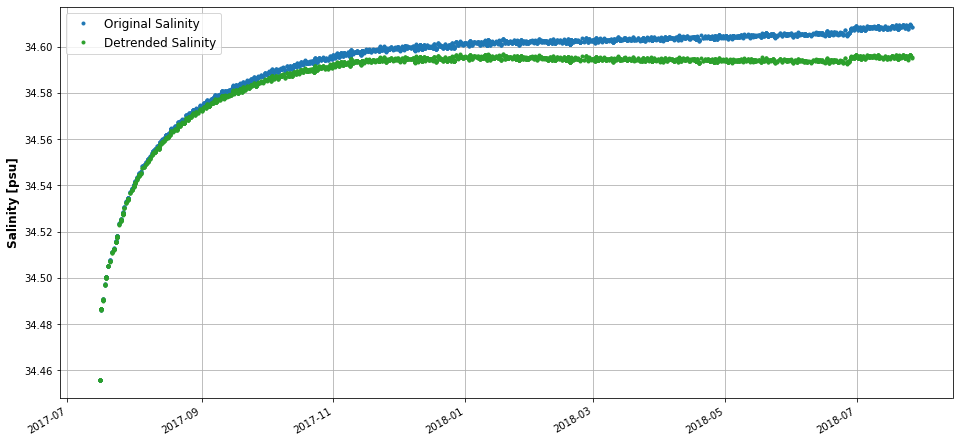

In [33]:
# Plot the detrended data
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(Data.time[mask], Data.practical_salinity[mask], marker=".", color="tab:blue", linestyle="", label="Original Salinity")
ax.plot(sal_no_trend.time, sal_no_trend, color="tab:green", marker=".", linestyle="", label="Detrended Salinity")
ax.grid()
ax.set_ylabel("Salinity [psu]", fontsize=12, weight="bold")
ax.legend(fontsize=12)

fig.autofmt_xdate()

In [34]:
# Calculate the reference salinity
ref_sal = sal_no_trend[tmask].mean()

# Calculate the correction factor
slope = ref_sal / y

# Smooth the correction factor
df = slope.to_dataframe("slope")
df = df.rolling(window=11, center=True).mean()
df.fillna(value=slope.to_dataframe("slope"), inplace=True)
slope_smoothed = xr.DataArray(df["slope"], dims="time")

# Calculate the "corrected" salinity
sal_corrected = Data.practical_salinity*slope_smoothed

# Calculate the "corrected" salinity with the trend added back in
sal_corrected_w_trend = sal_corrected + trend.slope*t

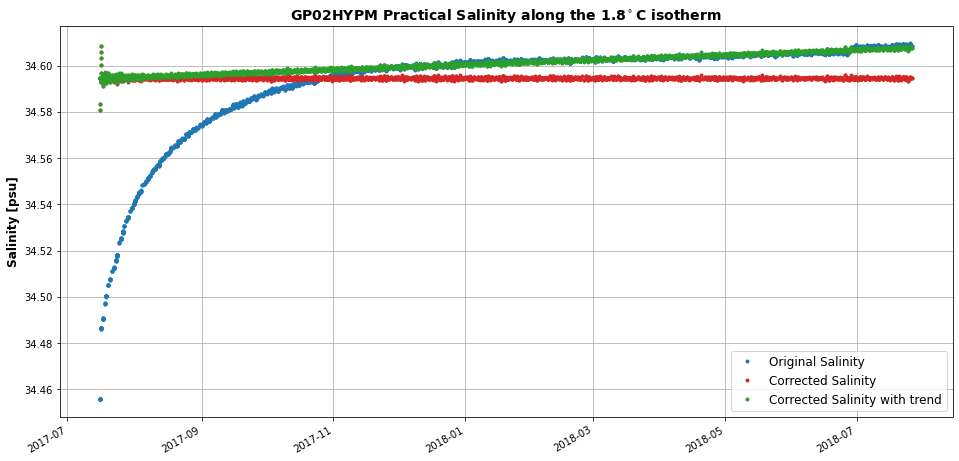

In [35]:
# Plot the original data, the corrected data, and the corrected data with trend added back in
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(Data.time[mask], Data.practical_salinity[mask], marker=".", color="tab:blue", linestyle="", label="Original Salinity")
ax.plot(sal_corrected.time, sal_corrected, color="tab:red", marker=".", linestyle="", label="Corrected Salinity")
ax.plot(sal_corrected_w_trend.time, sal_corrected_w_trend, color="tab:green", marker=".", linestyle="", label="Corrected Salinity with trend")
ax.grid()
ax.set_title(f"GP02HYPM Practical Salinity along the {isotherm}$^\circ$C isotherm", fontsize=14, fontweight="bold")
ax.set_ylabel("Salinity [psu]", fontsize=12, weight="bold")
ax.legend(fontsize=12)

fig.autofmt_xdate()

### Method 2: Calculate and remove the offset
Another option is to explicitily utilize the best-fit parameters which we previously fitted. The trend ${\alpha}t$ and initial conductivity $C_{0}$ may be used to apply the gain correction method outlined above. Alternatively, the values for ${\Delta}C_{0}$ and $\tau$ may be used with Equation 2 to explicitly calculate the values for the offset ${\Delta}C(t)$. The values for ${\Delta}C(t)$ are subtracted form the measured salinity to calculate the corrected salinity:<br><br>

<div align="center">
    $C_corr(t)=C_{obs}(t)-{\Delta}C(t)$
</div>

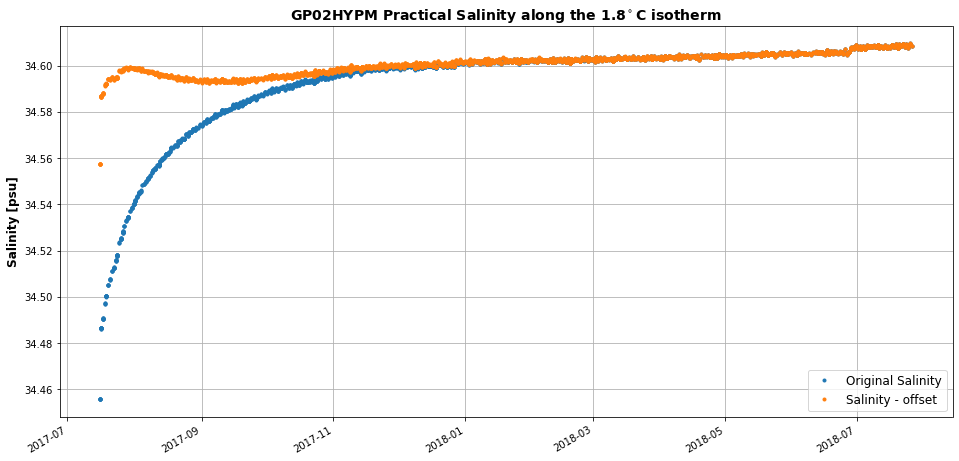

In [36]:
# Select the appropriate data along the given isotherm
mask = (Data.ctdpf_ckl_seawater_temperature >= isotherm-0.0005) & (Data.ctdpf_ckl_seawater_temperature <= isotherm + 0.0005)
t = Data.elapsed_time[mask] - Data.elapsed_time[mask][0]
y = Data.practical_salinity[mask]

# Get the appropriate parameters for the isotherm
a = results[results["isotherm"] == isotherm]["a"].values[0]
b = results[results["isotherm"] == isotherm]["b"].values[0]

# Calculate the offset using equation 3
offset = equation_three(t, a, b)

# Remove the offset from the data
sal_no_offset = y - offset

# Plot the results
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(Data.time[mask], Data.practical_salinity[mask], marker=".", color="tab:blue", linestyle="", label="Original Salinity")
ax.plot(sal_no_offset.time, sal_no_offset, color="tab:orange", marker=".", linestyle="", label="Salinity - offset")
ax.grid()
ax.set_title(f"GP02HYPM Practical Salinity along the {isotherm}$^\circ$C isotherm", fontsize=14, fontweight="bold")
ax.set_ylabel("Salinity [psu]", fontsize=12, weight="bold")
ax.legend(fontsize=12)

fig.autofmt_xdate()

In the above plot, you can see that explicitly calculating the offset and subtracting from the time series leaves some artifacts in the data. This is because the conductivity cell is not being _continuously_ flushed with water; rather, it is only flushed during a profile when the profiler is making sampling. A profile occurs once every 20 hours. Thus there is some hystersis in the data.

You can achieve a better fit using a two-exponential equation that takes into account two-different flushing rates with an equation such as:

<div align="center">
$Eq. 6: C_{obs}(t) = C_{sw}(t) + C_{TBT}(t_{0})*exp^{-t / {\tau}_{1}} + C_{other}(t_{0})*exp^{-t / {\tau}_{2}} + {\epsilon}$
</div>

You can then repeat the curve-fitting section above using Eq. 6. to find the best fits for ${\tau}_{1}$ and ${\tau}_{2}$ for the salinity data along isotherms. However, with two exponentials it is very, very important to provide decent initial guesses to the equation, otherwise it is unlikely that the fitting will converge on a solution.

In [37]:
def equation_six(t, a, b, c, d, f, g):
    return a * np.exp(-t / b) + c * np.exp(-t / d) + f*t + g

### Comparison of methods
Finally, we can plot and compare the different methods of correcting the salinity data. With these results, you can decide on which method best suites our needs

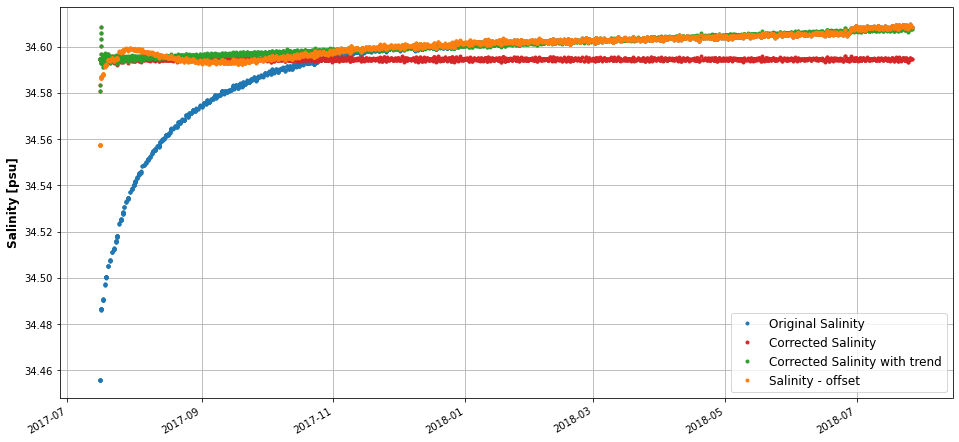

In [39]:
# Plot the original data, the corrected data, and the corrected data with trend added back in
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(Data.time[mask], Data.practical_salinity[mask], marker=".", color="tab:blue", linestyle="", label="Original Salinity")
ax.plot(sal_corrected.time, sal_corrected, color="tab:red", marker=".", linestyle="", label="Corrected Salinity")
ax.plot(sal_corrected_w_trend.time, sal_corrected_w_trend, color="tab:green", marker=".", linestyle="", label="Corrected Salinity with trend")
ax.plot(sal_no_offset.time, sal_no_offset, color="tab:orange", marker=".", linestyle="", label="Salinity - offset")
ax.grid()
ax.set_ylabel("Salinity [psu]", fontsize=12, weight="bold")
ax.legend(fontsize=12)

fig.autofmt_xdate()

---
## Conclusion

After stepping through several various methods of correcting the measured salinity for TBT interference, the gain correction method suggested by SeaBird, modified with a trend term, performs the best. It is possible to develop more complex models of the measured time series to correct the time series. Furthermore, the process outlined above does not attempt to assess the accuracy of the conductivity and salinity of the wire following profiler; OOI performs CTD casts and collects discrete water samples for bench-top salinity analysis at both the deployment and recovery of the profilers, which can be used to assess the accuracy of the measured salinity.